# Description synthétique du projet et de ses objectifs

# Installation

In [ ]:
%%capture
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

# Importation

In [ ]:
import openmeteo_requests

import requests_cache
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.api import tsa
import seaborn as sns
from retry_requests import retry
from statsmodels.tsa import stattools
from sklearn.model_selection import train_test_split
import numpy as np
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings('ignore')

# Chargement des données

In [ ]:
path_current = '/content/drive/MyDrive/Bihar-project/Historical-weather-project/'
data_path = '/content/drive/MyDrive/Bihar-project/Historical-weather-project/data/hourly_dataframe.csv'
data_path_add_col = '/content/drive/MyDrive/Bihar-project/Historical-weather-project/data/hourly_dataframe_add_col.csv'

value_column = 'temperature_2m'
value_column_add = 'relative_humidity_2m'


## temperature_2m



In [ ]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 6.9904,
	"longitude": -5.7442,
	"start_date": "2020-01-01",
	"end_date": "2023-12-31",
	"hourly": "temperature_2m",
	"timezone": "GMT"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m

hourly_dataframe = pd.DataFrame(data = hourly_data)
hourly_dataframe.to_csv(f'{path_current}data/hourly_dataframe.csv', index=False)
hourly_dataframe.head()

Coordinates 6.994727611541748°N -5.77215576171875°E
Elevation 202.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


,date,temperature_2m
0,2020-01-01 00:00:00+00:00,21.734999
1,2020-01-01 01:00:00+00:00,19.834999
2,2020-01-01 02:00:00+00:00,19.785000
3,2020-01-01 03:00:00+00:00,19.484999
4,2020-01-01 04:00:00+00:00,20.334999


In [ ]:
hourly_dataframe = pd.read_csv(data_path)
hourly_dataframe_copy = hourly_dataframe.copy()
hourly_dataframe_copy['date'] = pd. to_datetime(hourly_dataframe_copy['date'])
hourly_dataframe_copy['date'] = hourly_dataframe_copy['date'] .dt.strftime ('%Y-%m-%d %H:%M')
hourly_dataframe_copy['date'] = pd. to_datetime(hourly_dataframe_copy['date'])
hourly_dataframe_copy.set_index('date', inplace=True, drop=True)
hourly_dataframe_copy = hourly_dataframe_copy.resample('3H').mean()

hourly_dataframe_copy.index.names=['Timestamp']
hourly_dataframe_copy.head()


<Axes: xlabel='Timestamp'>

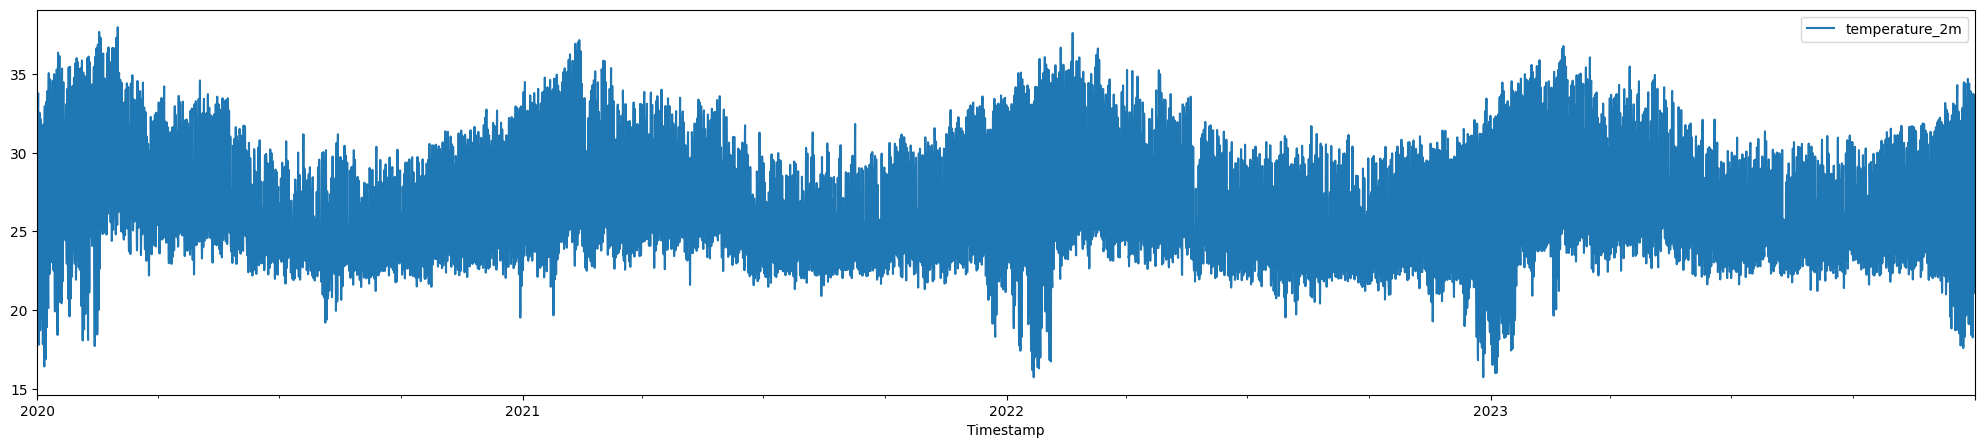

In [ ]:
hourly_dataframe_copy.plot(figsize=(25,5))

In [ ]:
ind_split = int(len(hourly_dataframe_copy) * 0.85)

ts_train = hourly_dataframe_copy[:ind_split]
ts_test = hourly_dataframe_copy[ind_split:]


## temperature_2m + relative_humidity_2m

In [ ]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 6.9904,
	"longitude": -5.7442,
	"start_date": "2020-01-01",
	"end_date": "2023-12-31",
	"hourly": ["temperature_2m", "relative_humidity_2m"],
	"timezone": "GMT"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m

hourly_dataframe_add_col = pd.DataFrame(data = hourly_data)
hourly_dataframe_add_col.to_csv(f'{path_current}data/hourly_dataframe_add_col.csv', index=False)
hourly_dataframe_add_col.head()

In [ ]:
hourly_dataframe_add_col.plot(figsize=(25,5))

In [ ]:
hourly_dataframe = pd.read_csv(data_path_add_col)
hourly_dataframe_add_col_copy = hourly_dataframe_add_col.copy()
hourly_dataframe_add_col_copy['date'] = pd.to_datetime(hourly_dataframe_add_col_copy['date'])
hourly_dataframe_add_col_copy['date'] = hourly_dataframe_add_col_copy['date'] .dt.strftime ('%Y-%m-%d %H:%M')
hourly_dataframe_add_col_copy['date'] = pd.to_datetime(hourly_dataframe_add_col_copy['date'])
hourly_dataframe_add_col_copy.set_index('date', inplace=True, drop=True)
hourly_dataframe_add_col_copy = hourly_dataframe_add_col_copy.resample('3H').mean()

hourly_dataframe_add_col_copy.index.names=['Timestamp']
hourly_dataframe_add_col_copy.head()

In [ ]:
ind_split = int(len(hourly_dataframe_add_col_copy) * 0.85)

ts_train_add_col = hourly_dataframe_add_col_copy[:ind_split]
ts_test_add_col = hourly_dataframe_add_col_copy[ind_split:]

# Analyse exploratoire et prétraitement des données

In [ ]:
ts_train_copy = ts_train.copy()
ts_test_copy = ts_test.copy()

In [ ]:
ts_train_add_col_copy = ts_train_add_col.copy()
ts_test_add_col_copy = ts_test_add_col.copy()

In [ ]:
def display_seasonal_decompose (data):
  res = tsa.seasonal_decompose(data)

  plt.rc("figure", figsize=(20, 10))

  fig, axes = plt.subplots(4, 1)

  res.observed.plot(ax=axes[0], legend=False)
  axes[0].set_ylabel('Observed')

  res.trend.plot(ax=axes[1], legend=False)
  axes[1].set_ylabel('Trend')

  res.seasonal.plot(ax=axes[2], legend=False)
  axes[2].set_ylabel('Seasonal')

  res.resid.plot(ax=axes[3], legend=False)
  axes[3].set_ylabel('Residual')

  plt.suptitle('Seasonal Decomposition of Temperature Time Series', fontsize=10)
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])

  plt.show()

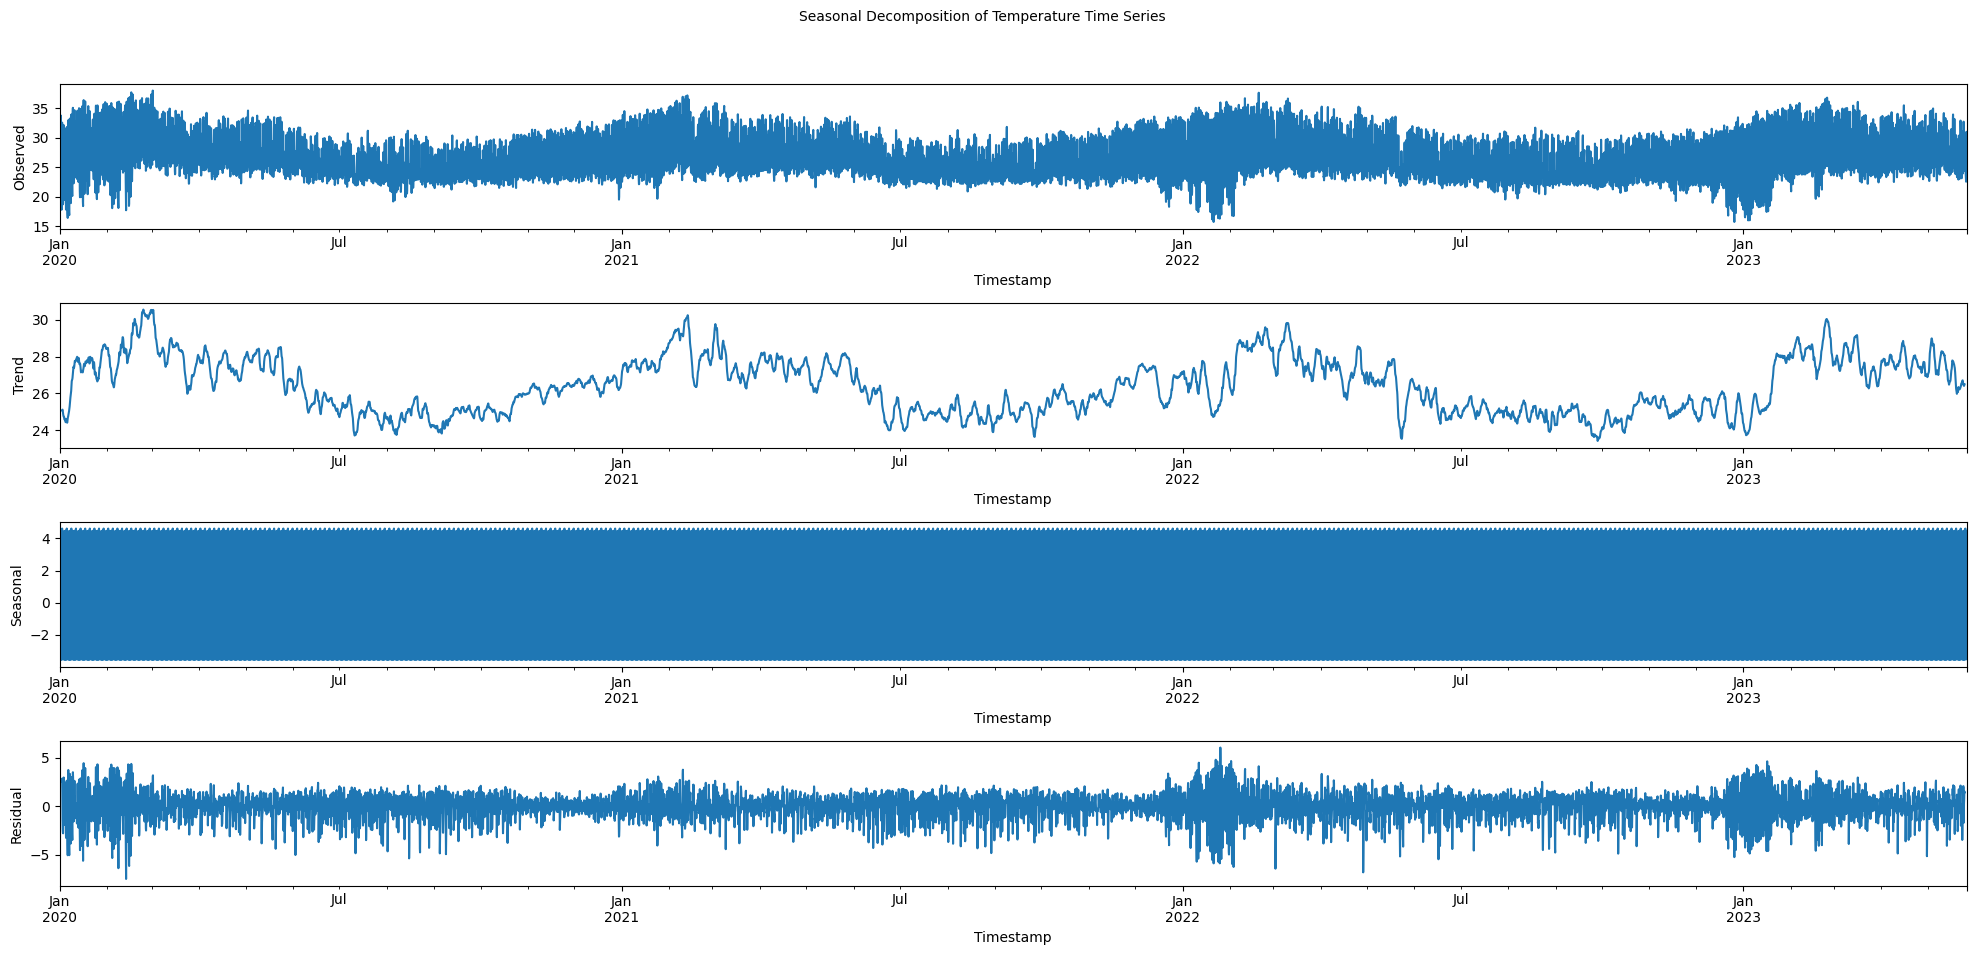

In [ ]:
display_seasonal_decompose(ts_train_copy)

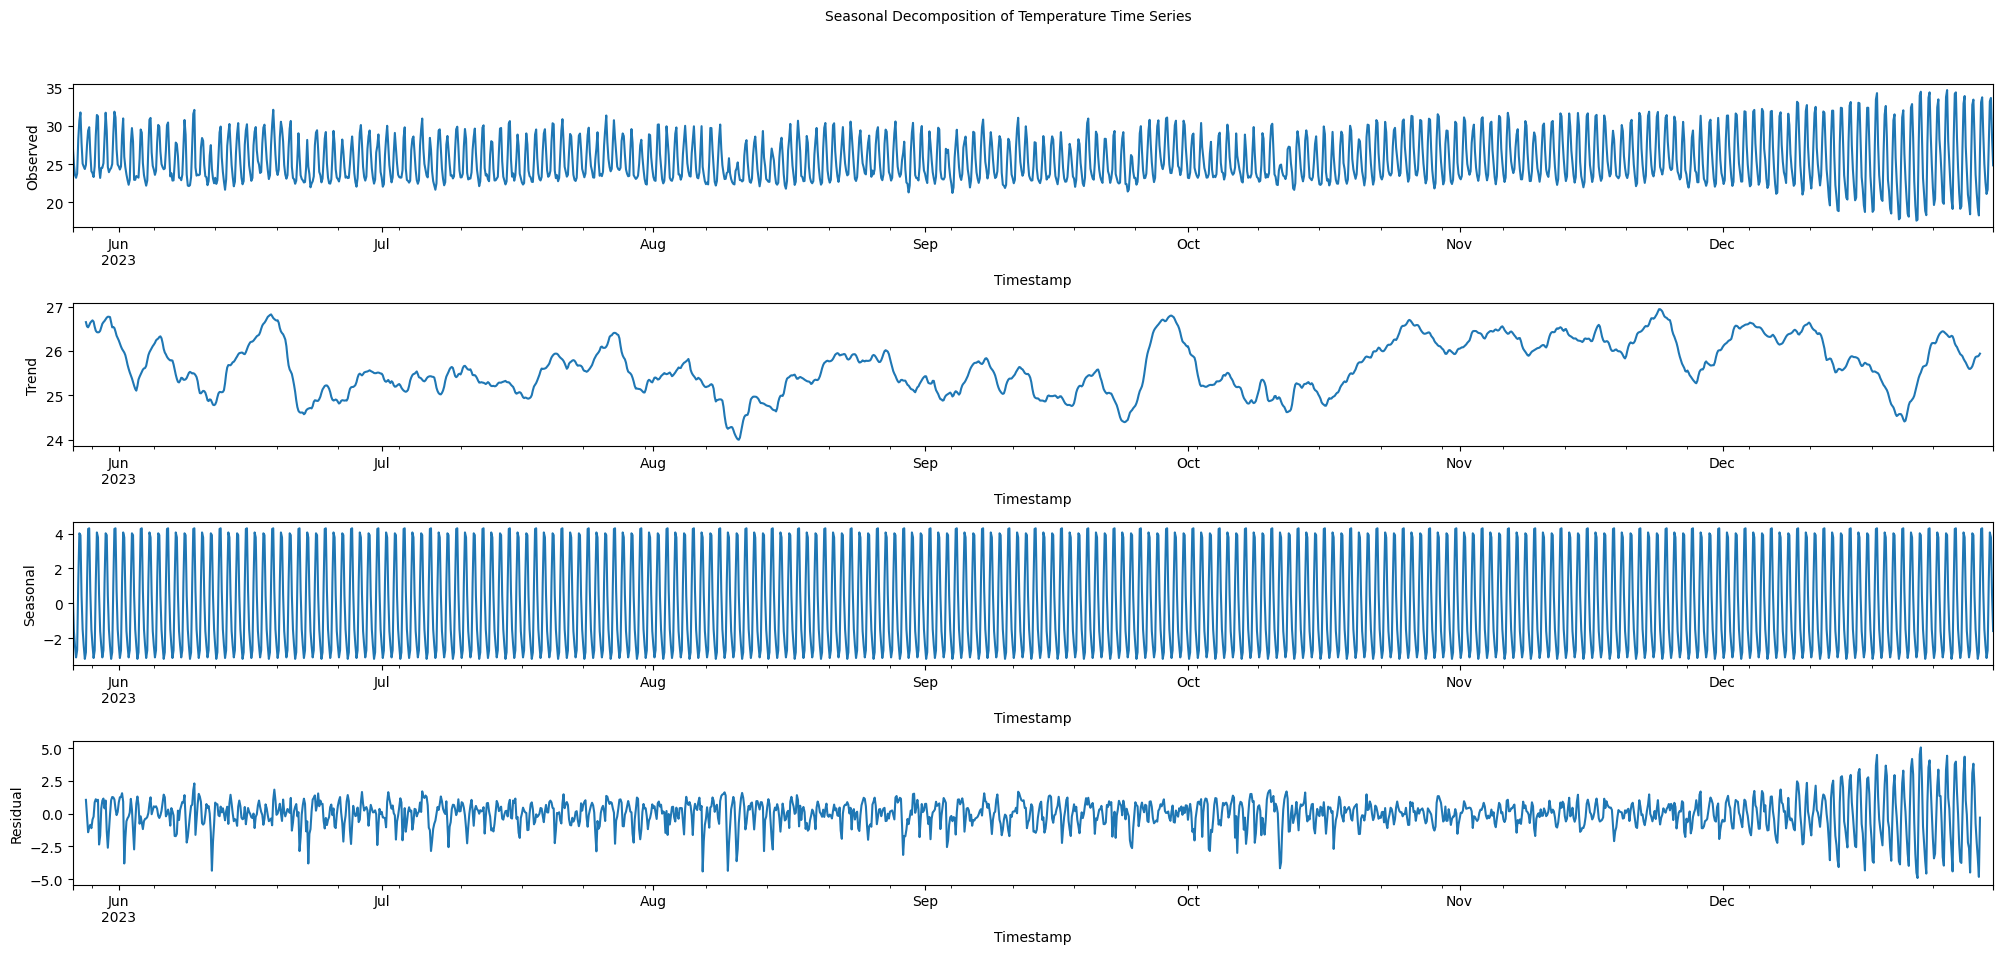

In [ ]:
display_seasonal_decompose(ts_test_copy)

In [ ]:

# Augmented Dickey-Fuller test
def check_adf_stat(ts,data_type):

  adf_results = stattools.adfuller(ts)
  adf_stat = adf_results[0]
  p_value = adf_results[1]
  critical_values = adf_results[4]

  print(f'The Augmented Dickey-Fuller test results on {data_type}\
          \n  test statistic {adf_stat:.3f},\
          \n  p-value: {p_value:.3f}\
          \n  critical values: {critical_values}')

  if (p_value > 0.05) or (adf_stat > critical_values['5%']):
    # there is a unit root
    print('The time series is NOT stationary')
  else:
    # there is no unit roots
    print('The time series is stationary')

warnings.filterwarnings('ignore')

# Kwiatkowski–Phillips–Schmidt–Shin test
def check_kpss_stat(ts, data_type):

  kpss_results = stattools.kpss(ts)
  kpss_stat = kpss_results[0]
  p_value = kpss_results[1]
  critical_values = kpss_results[3]

  print(f'The KPSS test results on {data_type}\
        \n  test statistic {kpss_stat:.3f},\
        \n  p-value: {p_value:.3f}\
        \n  critical values: {critical_values}')

  if (p_value > 0.05) or (kpss_stat < critical_values['5%']):
      print('The time series is stationary')
  else:
      print('The time series is NOT stationary')

warnings.filterwarnings('ignore')

In [ ]:
check_adf_stat(ts_train_copy, 'Train')
print("----"*50)
check_kpss_stat(ts_train_copy, 'Train')
print("++++"*60)
check_adf_stat(ts_test_copy, 'Test')
print("----"*50)
check_kpss_stat(ts_test_copy, 'Test')

The Augmented Dickey-Fuller test results on Train          
  test statistic -5.177,          
  p-value: 0.000          
  critical values: {'1%': -3.4310110406491767, '5%': -2.8618321403033673, '10%': -2.5669255011501515}
The time series is stationary
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
The KPSS test results on Train        
  test statistic 1.043,        
  p-value: 0.010        
  critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The time series is NOT stationary
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
The Augmented Dickey-Fuller test results on Test          
  test statistic -5.486,          
  p-v

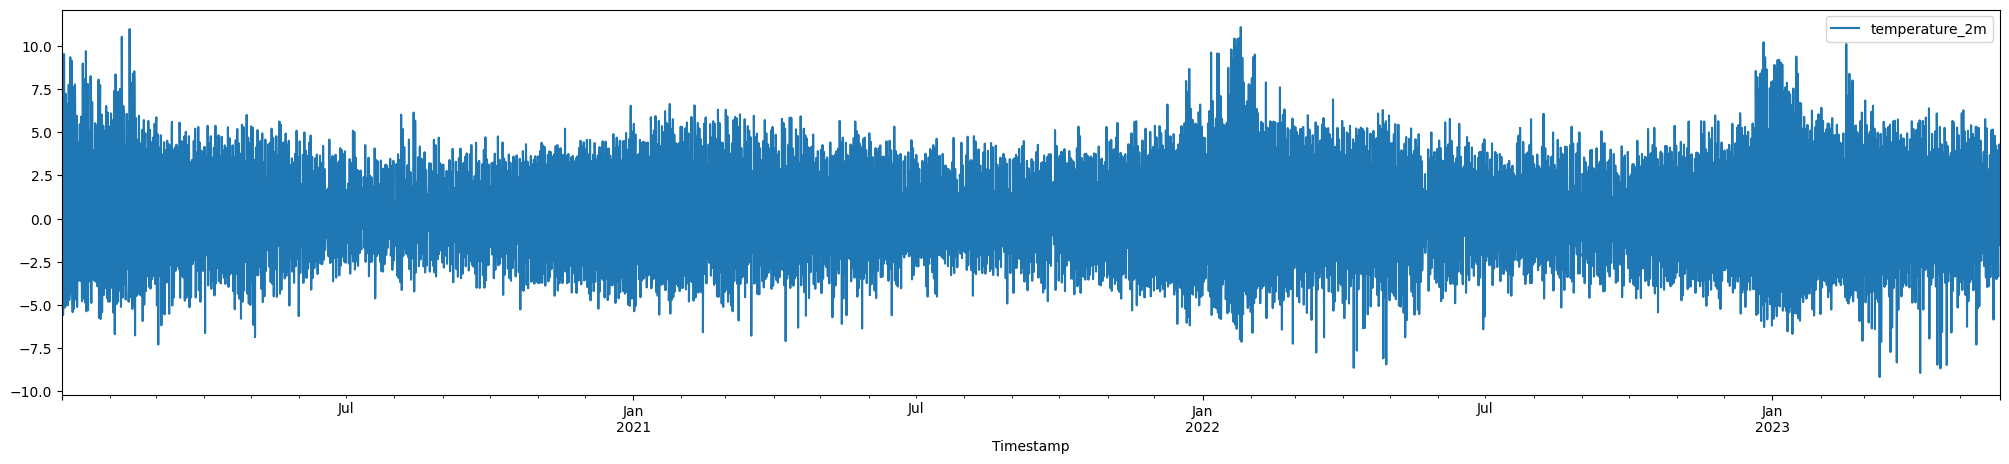

In [ ]:
diff_y_train_copy = (ts_train_copy - ts_train_copy.shift(1))

diff_y_train_copy.dropna(inplace=True)
diff_y_train_copy.plot(figsize=(25,5));

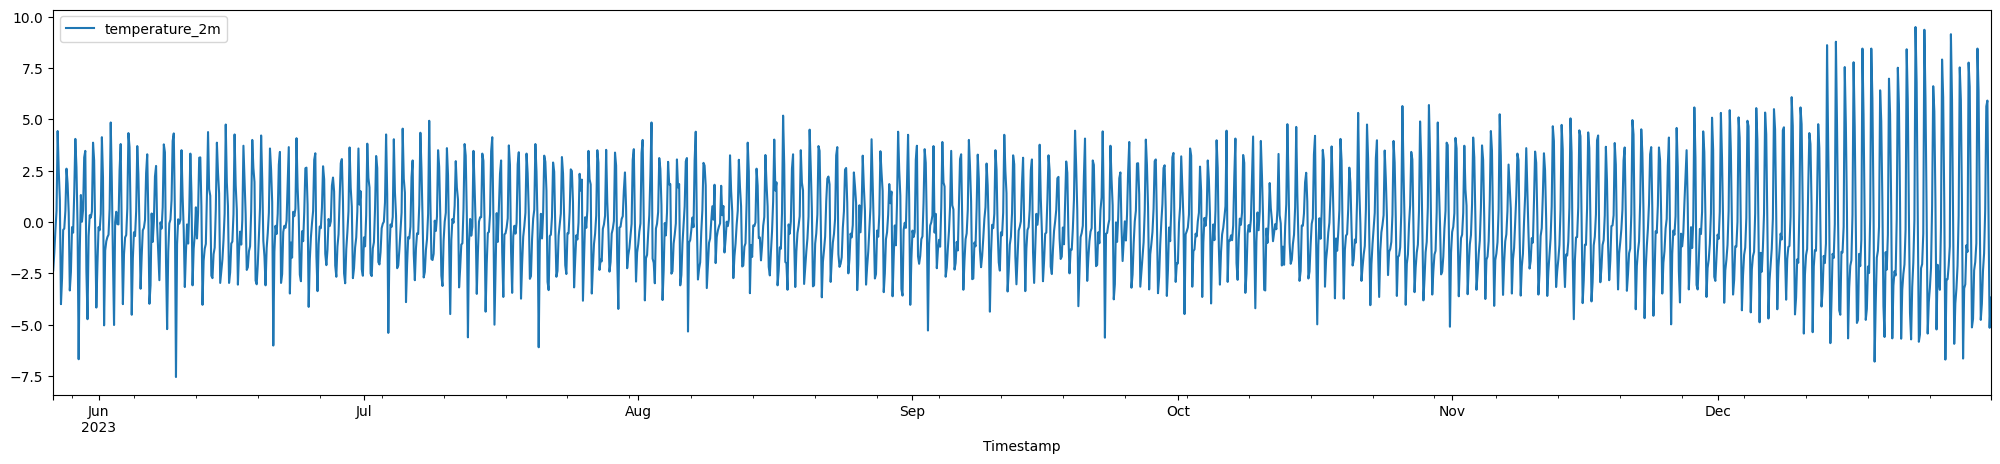

In [ ]:
diff_y_test_copy = (ts_test_copy - ts_test_copy.shift(1))

diff_y_test_copy.dropna(inplace=True)
diff_y_test_copy.plot(figsize=(25,5));

In [ ]:
check_adf_stat(diff_y_train_copy, 'Train')
print("----"*50)
check_kpss_stat(diff_y_train_copy, 'Train')
print("++++"*60)
check_adf_stat(diff_y_test_copy, 'Test')
print("----"*50)
check_kpss_stat(diff_y_test_copy, 'Test')

The Augmented Dickey-Fuller test results on Train          
  test statistic -25.287,          
  p-value: 0.000          
  critical values: {'1%': -3.431011107478798, '5%': -2.8618321698347633, '10%': -2.5669255168697633}
The time series is stationary
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
The KPSS test results on Train        
  test statistic 0.006,        
  p-value: 0.100        
  critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The time series is stationary
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
The Augmented Dickey-Fuller test results on Test          
  test statistic -13.141,          
  p-valu

### Seasonal differencing

From the figure we can see that the pattern is repeated every ....time steps (months).

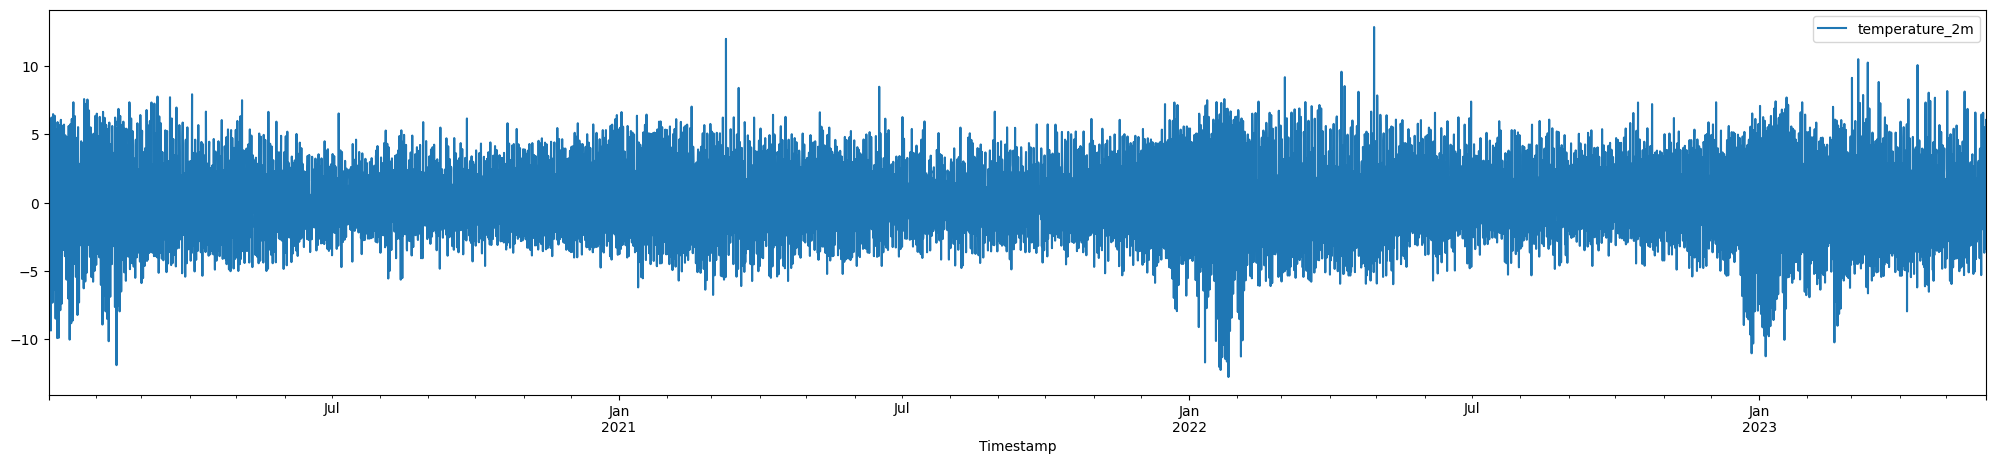

In [ ]:
s = 7
sdiff_y_train_copy = (diff_y_train_copy - diff_y_train_copy.shift(s))[s:]

sdiff_y_train_copy.dropna(inplace=True)
sdiff_y_train_copy.plot(figsize=(25,5));

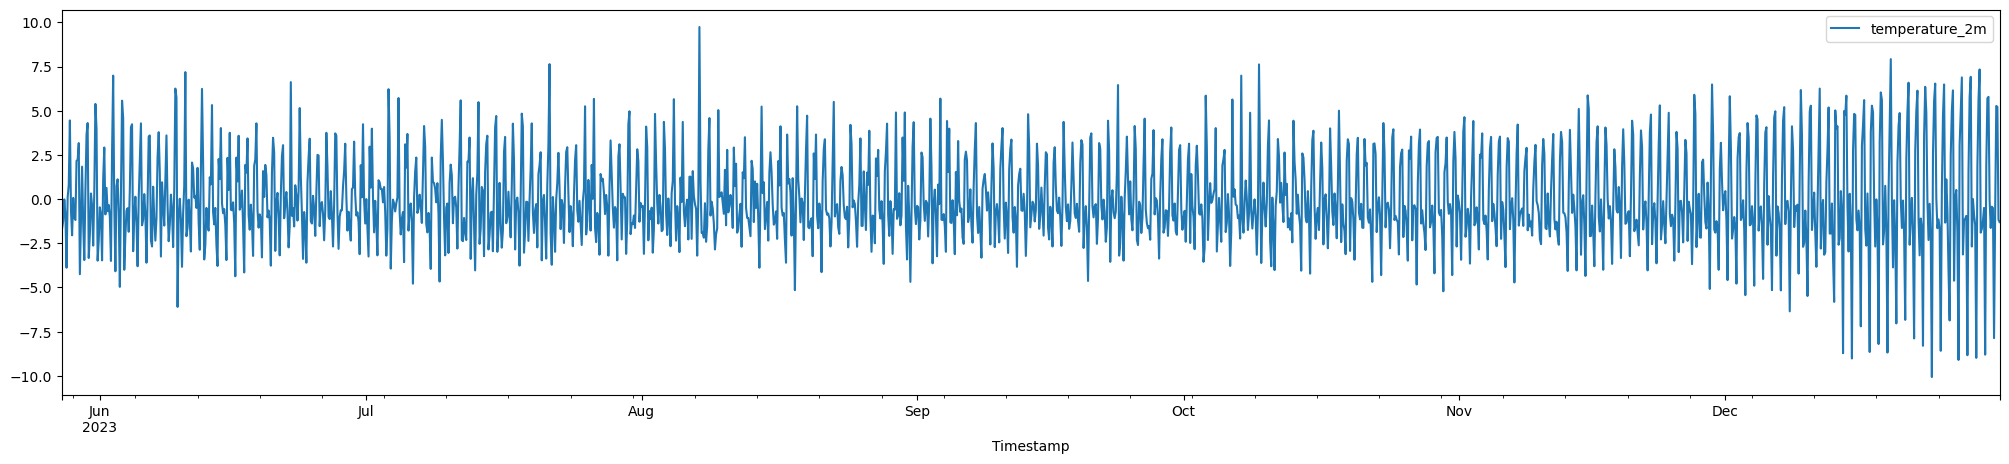

In [ ]:
s = 7
sdiff_y_test_copy = (diff_y_test_copy - diff_y_test_copy.shift(s))[s:]

sdiff_y_test_copy.dropna(inplace=True)
sdiff_y_test_copy.plot(figsize=(25,5));

In [ ]:
check_adf_stat(sdiff_y_train_copy, 'Train')
print("----"*50)
check_kpss_stat(sdiff_y_train_copy, 'Train')
print("++++"*60)
check_adf_stat(sdiff_y_test_copy, 'Test')
print("----"*50)
check_kpss_stat(sdiff_y_test_copy, 'Test')

The Augmented Dickey-Fuller test results on Train          
  test statistic -29.375,          
  p-value: 0.000          
  critical values: {'1%': -3.4310115756647677, '5%': -2.8618323767218277, '10%': -2.5669256269961007}
The time series is stationary
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
The KPSS test results on Train        
  test statistic 0.063,        
  p-value: 0.100        
  critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The time series is stationary
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
The Augmented Dickey-Fuller test results on Test          
  test statistic -13.663,          
  p-val

In [ ]:
y_train_log = np.log(ts_train_copy)
y_test_log = np.log(ts_test_copy)

<Axes: xlabel='Timestamp'>

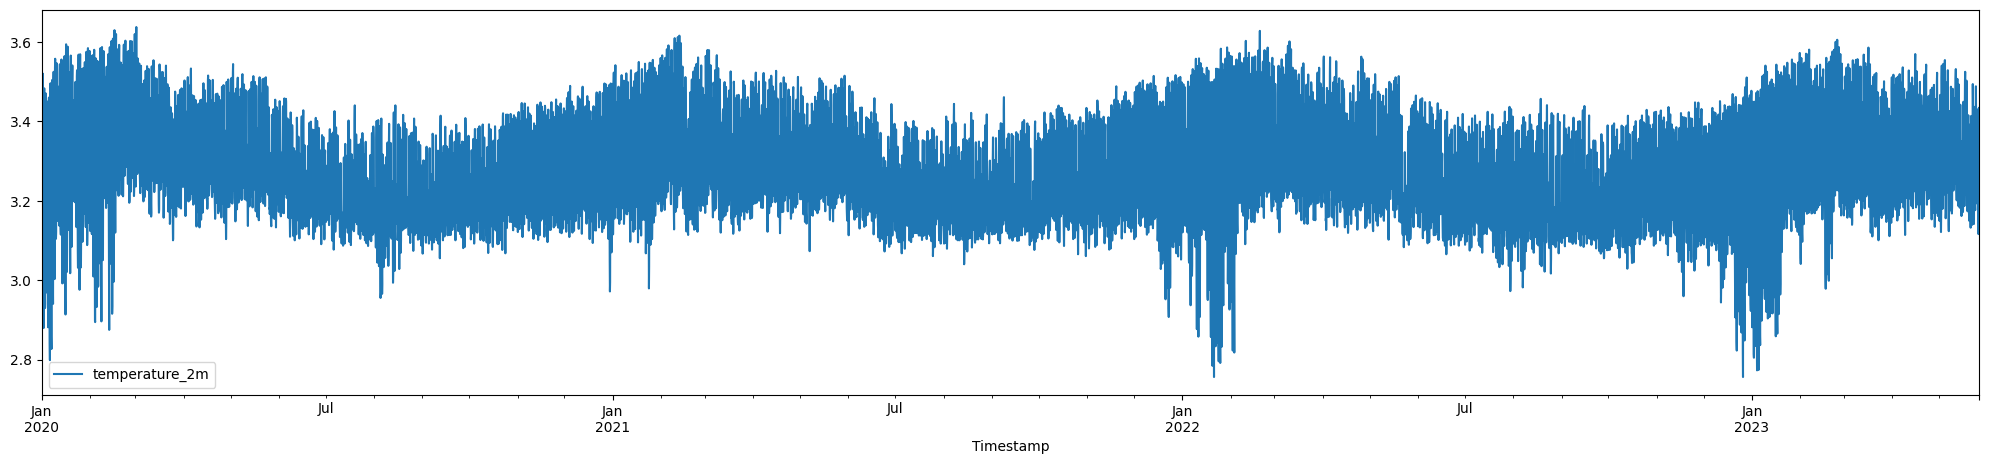

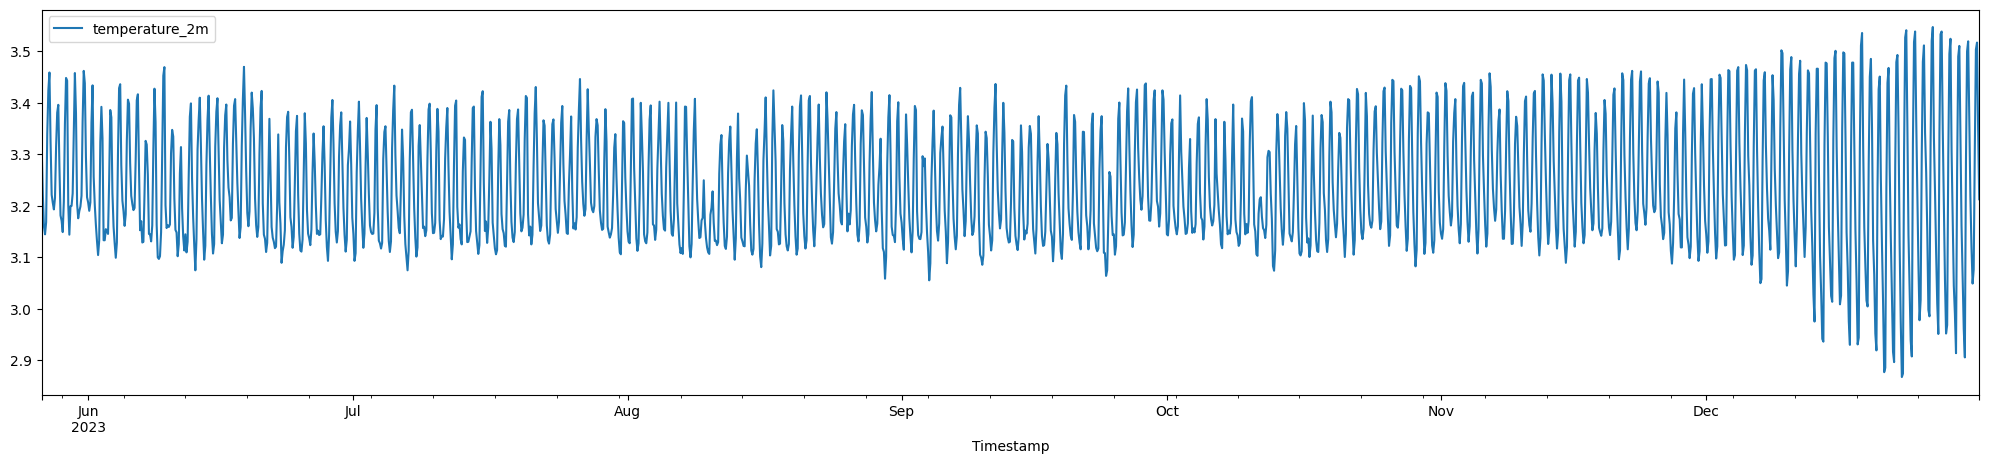

In [ ]:
y_train_log.plot(figsize=(25,5))
y_test_log.plot(figsize=(25,5))

### Autocorrelaction function (ACF)

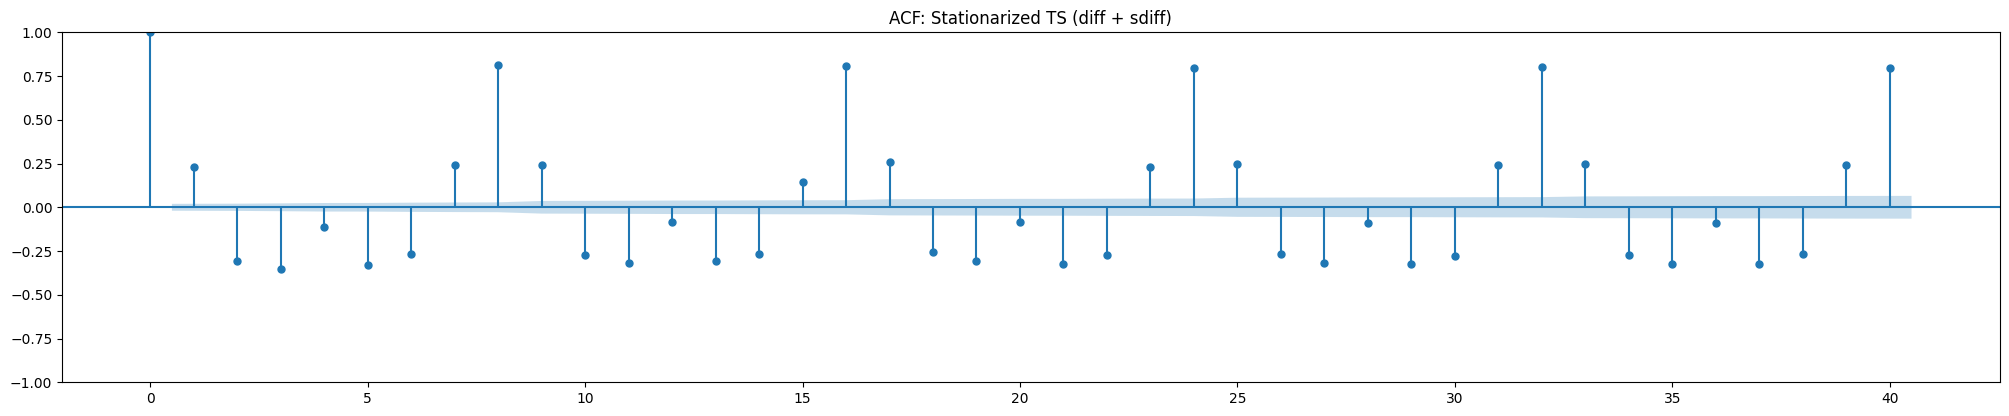

In [ ]:
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_acf(sdiff_y_train_copy, lags=40, ax=ax1, title="ACF: Stationarized TS (diff + sdiff)");

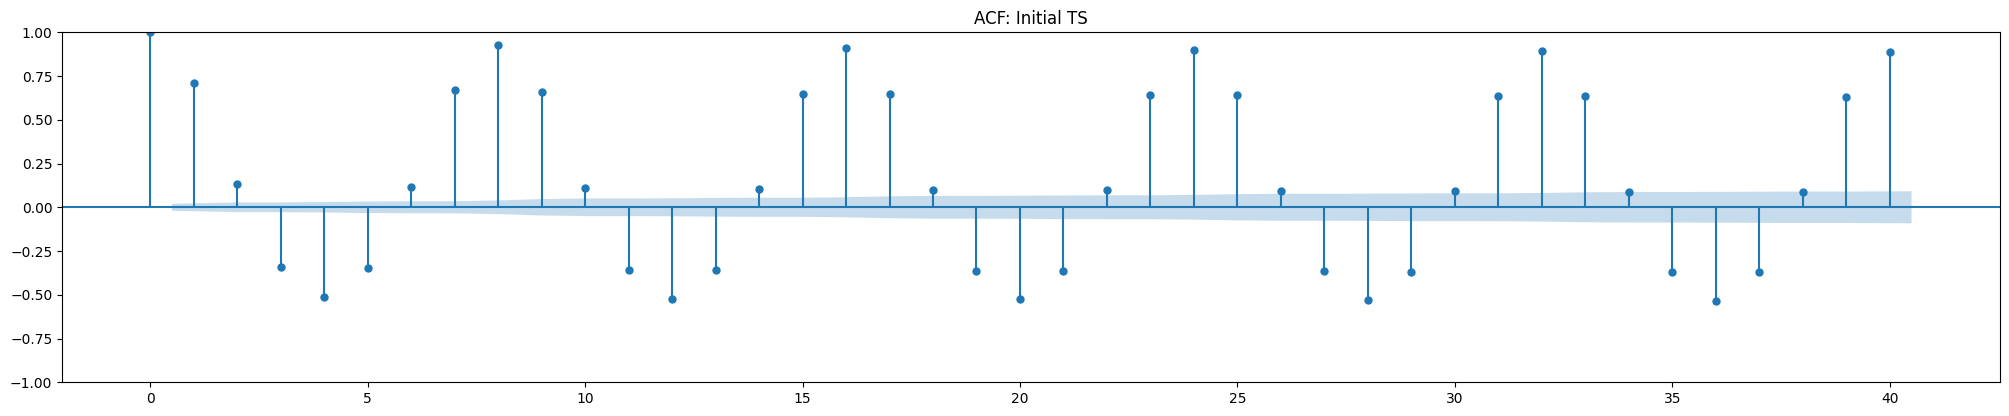

In [ ]:
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_acf(ts_train_copy, lags=40, ax=ax1, title="ACF: Initial TS");

### Partial Autocorrelation function (PACF)

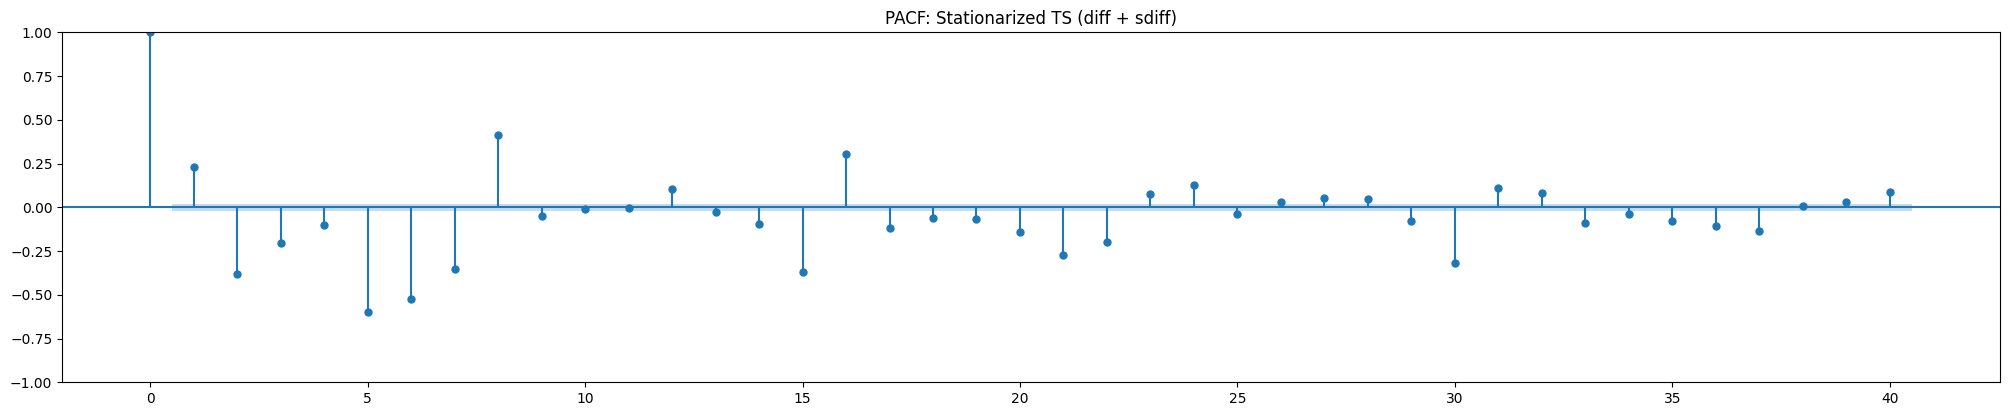

In [ ]:
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot(211)
tsaplots.plot_pacf(sdiff_y_train_copy, lags=40, ax=ax1, title="PACF: Stationarized TS (diff + sdiff)");


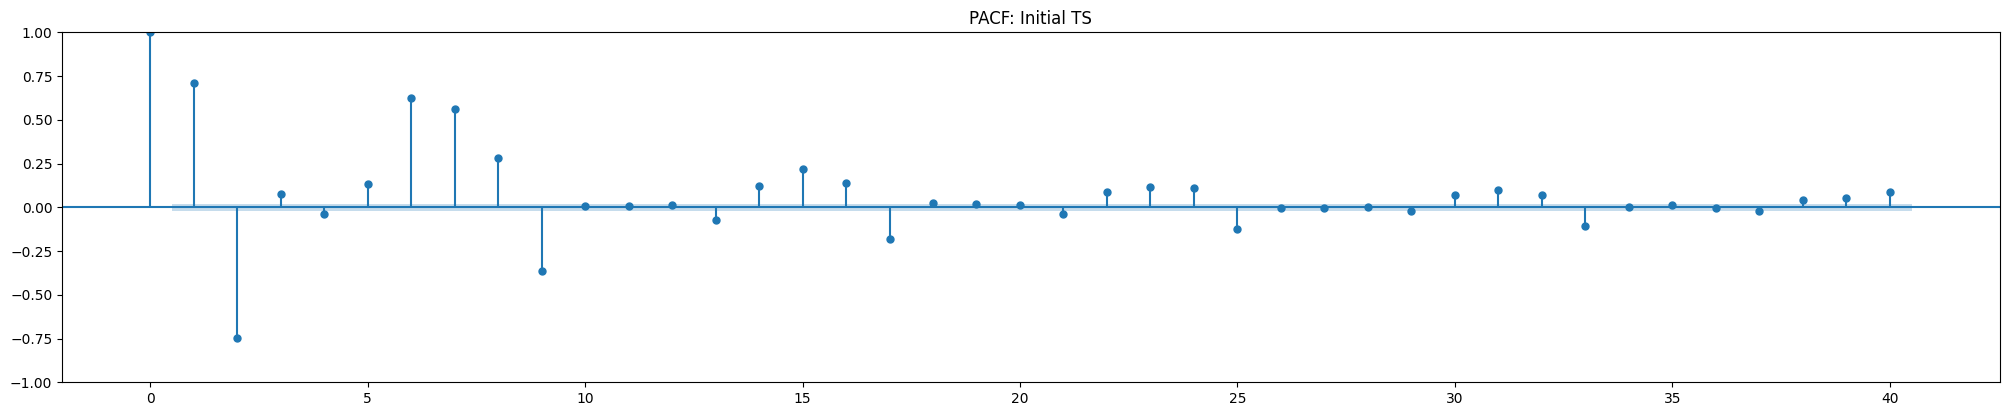

In [ ]:
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_pacf(ts_train_copy, lags=40, ax=ax1, title="PACF: Initial TS")

# Modélisation et évaluation des perfo rmances des modèles

### ARIMA

In [ ]:
order=(10,1,11)

model = ARIMA(ts_train_copy, order=order).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:         temperature_2m   No. Observations:                 9934
Model:               ARIMA(10, 1, 11)   Log Likelihood              -12393.922
Date:                Sat, 06 Apr 2024   AIC                          24831.845
Time:                        14:51:32   BIC                          24990.324
Sample:                    01-01-2020   HQIC                         24885.507
                         - 05-26-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3440      0.156     -2.202      0.028      -0.650      -0.038
ar.L2         -0.0796      0.138     -0.576      0.564      -0.350       0.191
ar.L3         -0.2151      0.059     -3.638      0.0

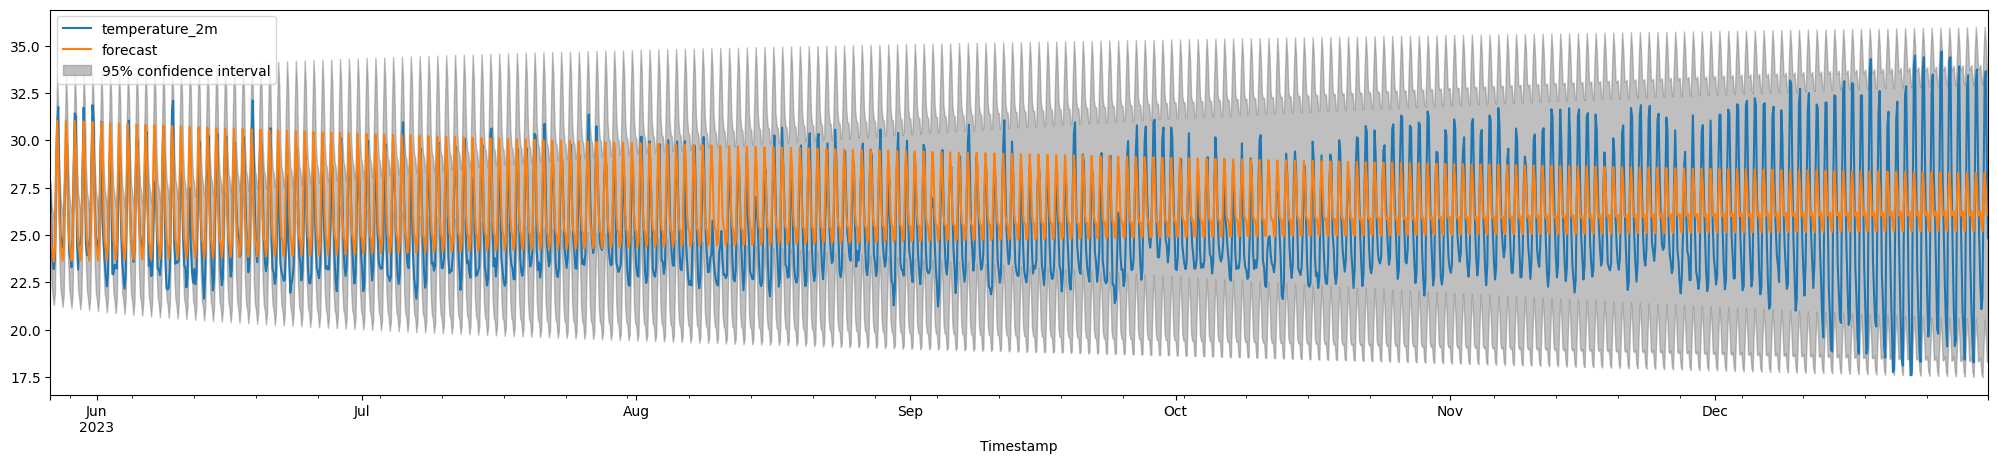

In [ ]:
fig, ax = plt.subplots(figsize=(25,5))
ax = ts_test_copy.plot(ax=ax)
fig = plot_predict(model, start=ts_test_copy.index[0], end=ts_test_copy.index[-1], dynamic=False, ax=ax)
legend = ax.legend(loc="upper left")

In [ ]:
# From PACF plot
p_values = range(5,12)
# From ACF plot
q_values = range(5,12)
# We saw that single differencing transformed the ts into a stationary one
d_values = range(1,3)

In [ ]:

best_order_aic_score_1, best_order_aic_cfg_1 = float("inf"), None

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                model = ARIMA(ts_train_copy, order=order).fit()
                if model.aic < best_order_aic_score_1:
                    best_order_aic_score_1, best_order_aic_cfg_1 = model.aic, order
                    print(f'ARIMA{order} AIC={model.aic:.3f}')
            except:
                continue

print(f'Best ARIMA{best_order_aic_cfg_1} AIC={best_order_aic_score_1:.3f}')

ARIMA(5, 1, 5) AIC=26791.384
ARIMA(5, 1, 6) AIC=26434.143
ARIMA(5, 1, 7) AIC=25842.166
ARIMA(5, 1, 8) AIC=25752.048
ARIMA(5, 1, 9) AIC=25585.845
ARIMA(7, 1, 9) AIC=25418.398
ARIMA(7, 1, 10) AIC=25127.321
ARIMA(7, 1, 11) AIC=25037.097
ARIMA(8, 1, 9) AIC=24870.772
ARIMA(8, 1, 11) AIC=24830.355
ARIMA(9, 1, 8) AIC=24826.568
Best ARIMA(9, 1, 8) AIC=24826.568


### SARIMA

In [ ]:
order=(10,1,11)

model_sa = SARIMAX(ts_train_copy, order=order).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:         temperature_2m   No. Observations:                 9934
Model:               ARIMA(11, 2, 11)   Log Likelihood              -12485.041
Date:                Sat, 06 Apr 2024   AIC                          25016.083
Time:                        14:47:17   BIC                          25181.764
Sample:                    01-01-2020   HQIC                         25072.184
                         - 05-26-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1996      0.182     -6.575      0.000      -1.557      -0.842
ar.L2         -1.2572      0.215     -5.840      0.000      -1.679      -0.835
ar.L3         -1.1807      0.146     -8.084      0.0

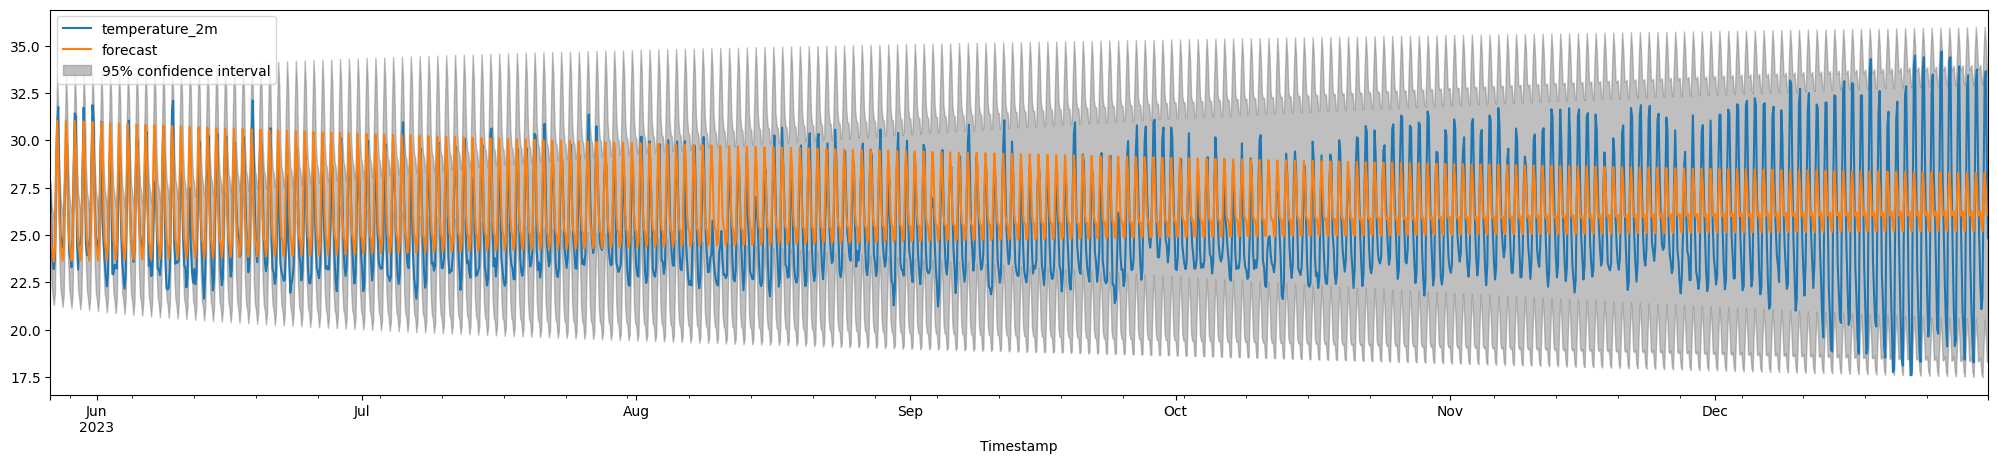

In [ ]:
fig, ax = plt.subplots(figsize=(25,5))
ax = ts_test_copy.plot(ax=ax)
fig = plot_predict(model_sa, start=ts_test_copy.index[0], end=ts_test_copy.index[-1], dynamic=False, ax=ax)
legend = ax.legend(loc="upper left")

### SARIMAX

In [ ]:

best_order_aic_score, best_order_aic_cfg = float("inf"), None

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                model_sa_t = SARIMAX(ts_train_copy, order=order).fit()
                if model_sa_t.aic < best_order_aic_score:
                    best_order_aic_score, best_order_aic_cfg = model_sa_t.aic, order
                    print(f'SARIMAX{order} AIC={model_sa_t.aic:.3f}')
            except:
                continue

print(f'Best SARIMAX{best_order_aic_cfg} AIC={best_order_aic_score:.3f}')

SARIMAX(5, 1, 5) AIC=26791.384
SARIMAX(5, 1, 6) AIC=26434.143
SARIMAX(5, 1, 7) AIC=25842.166
SARIMAX(5, 1, 8) AIC=25752.048
SARIMAX(5, 1, 9) AIC=25585.845
SARIMAX(7, 1, 9) AIC=25418.398
SARIMAX(7, 1, 10) AIC=25127.321
SARIMAX(7, 1, 11) AIC=25037.097
SARIMAX(8, 1, 9) AIC=24870.772
SARIMAX(8, 1, 11) AIC=24830.355
SARIMAX(9, 1, 8) AIC=24826.568
Best SARIMAX(9, 1, 8) AIC=24826.568


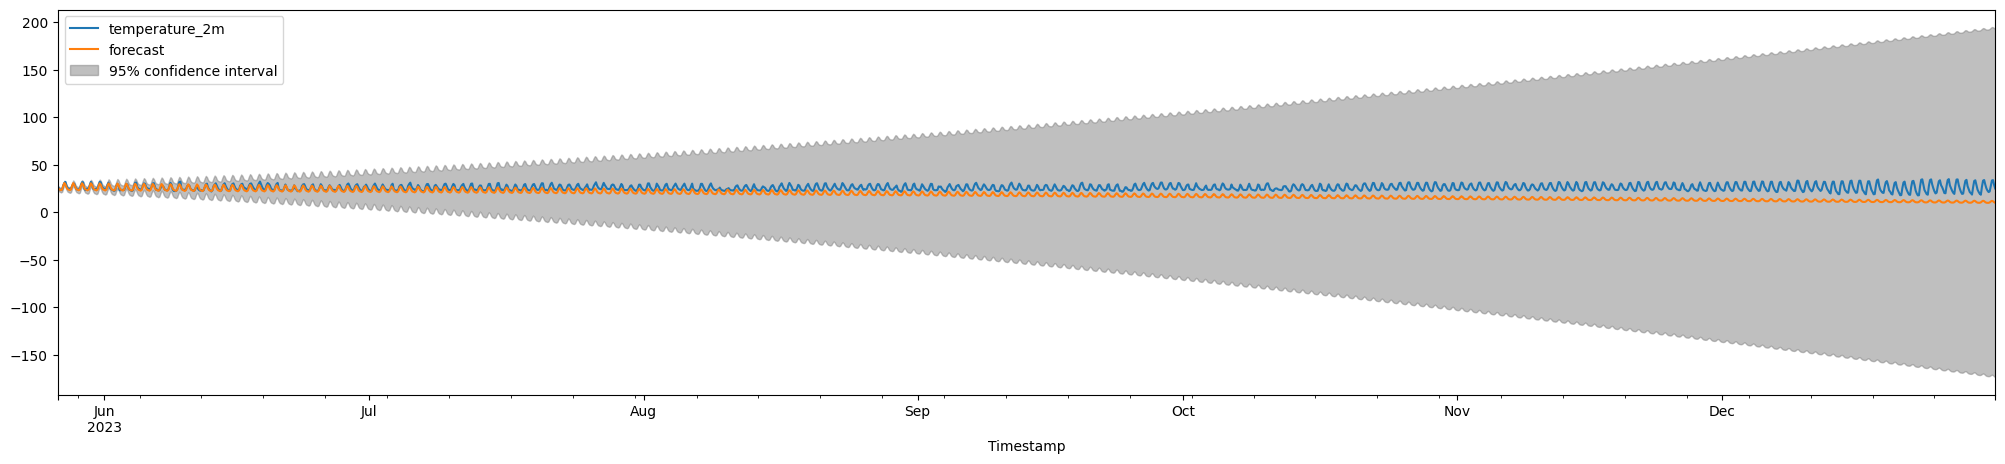

In [ ]:
fig, ax = plt.subplots(figsize=(25,5))
ax = ts_test_copy.plot(ax=ax)
fig = plot_predict(model_sa_t, start=ts_test_copy.index[0], end=ts_test_copy.index[-1], dynamic=False, ax=ax)
legend = ax.legend(loc="upper left")

#### mean_squared_error

In [ ]:
p_values = range(5,12)
q_values = range(5,12)
d_values = range(1,2)

In [ ]:
best_score_rmse, best_cfg_rmse = float("inf"), None

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                model_sa_t_rmse = SARIMAX(ts_train_copy, order=order).fit()
                ts_pred = model_sa_t_rmse.predict(start=ts_test_copy.index[0], end=ts_test_copy.index[-1])
                rmse = mean_squared_error(ts_test_copy.values, ts_pred.values, squared=False)

                if rmse < best_score_rmse:
                    best_score_rmse, best_cfg_rmse = rmse, order
                    print(f'SARIMAX{order} RMSE={rmse:.3f}')
            except:
                continue

print(f'Best SARIMAX{best_cfg_rmse} RMSE={best_score_rmse:.3f}')

SARIMAX(5, 1, 5) RMSE=2.483
SARIMAX(5, 1, 6) RMSE=2.282
SARIMAX(5, 1, 7) RMSE=1.709
Best SARIMAX(5, 1, 7) RMSE=1.709


#### mean_squared_error | AIC

In [ ]:
best_order = (5,1,7)

model_sarimax = SARIMAX(ts_train_copy, order=best_order).fit()
ts_pred = model_sarimax.predict(start=ts_test_copy.index[0], end=ts_test_copy.index[-1])
rmse = mean_squared_error(ts_test_copy.values, ts_pred.values, squared=False)
print(f'SARIMAX{best_order} | nAIC = {model_sarimax.aic:.2f} | RMSE (test)={rmse:.2f}')

SARIMAX(5, 1, 7) | nAIC = 25842.17 | RMSE (test)=1.71


#### plot

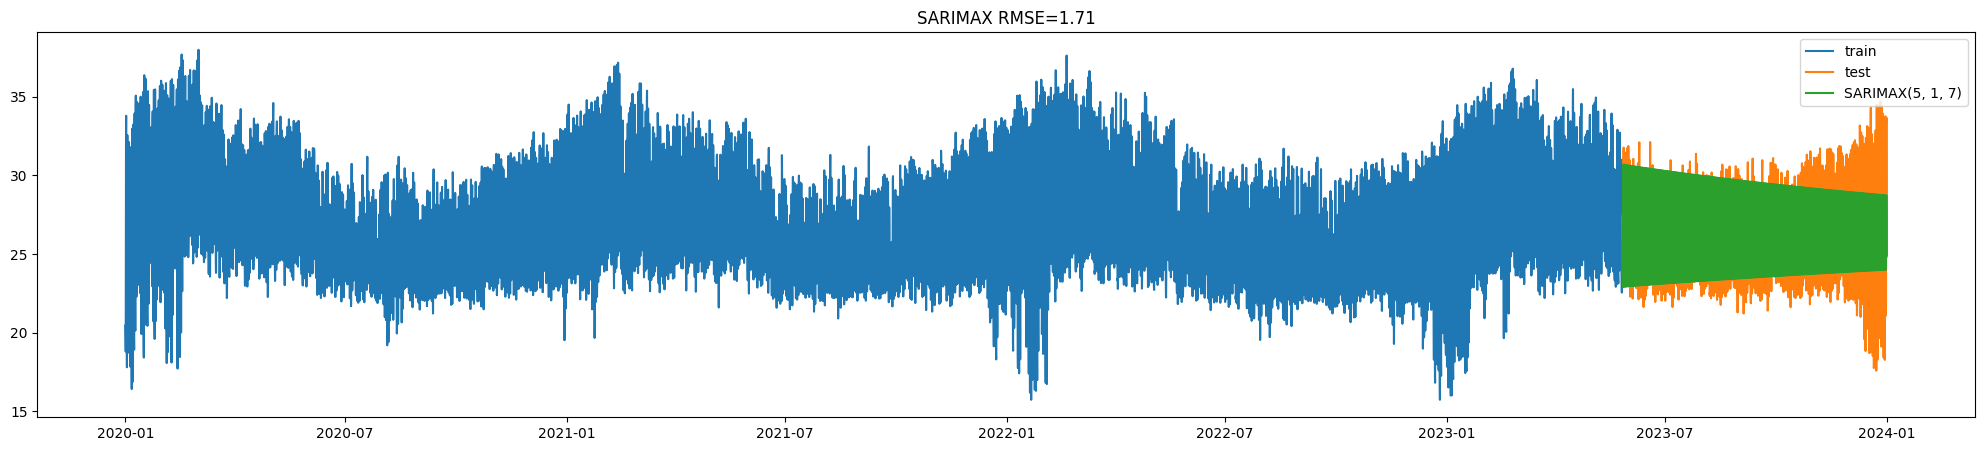

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(ts_train_copy.index, ts_train_copy.values, label='train')
plt.plot(ts_test_copy.index, ts_test_copy.values, label='test')
plt.plot(ts_pred.index, ts_pred.values, label=f'SARIMAX{best_order}')
plt.legend(loc='best')
plt.title(f'SARIMAX RMSE={rmse:.2f}')
plt.show()

#### seasonal_order

In [ ]:
P_values = range(0,12)
Q_values = range(0,12)
D_values = range(1,2)
s = 7

In [ ]:
order = (5,1,7)
best_score_aic, best_cfg_aic = float("inf"), None

for P in P_values:
    for D in D_values:
        for Q in Q_values:
            seasonal_order=(P, D, Q, s)
            try:
                model = SARIMAX(ts_train_copy, order=order, seasonal_order=seasonal_order).fit()
                if model.aic < best_score_aic:
                    best_score_aic, best_cfg_aic = model.aic, seasonal_order
                    print(f'SARIMAX{order}{seasonal_order} AIC={model.aic:.3f}')
            except:
                continue

print(f'Best SARIMAX{order}{best_cfg_aic} AIC={best_score_aic:.3f}')



Best SARIMAX(5, 1, 7)None AIC=inf


In [ ]:
order = (5,1,7)
seasonal_order = (1, 1, 2, 9)

model_sarimax = SARIMAX(ts_train_copy, order=best_order).fit()
ts_pred = model_sarimax.predict(start=ts_test_copy.index[0], end=ts_test_copy.index[-1])
rmse = mean_squared_error(ts_test_copy.values, ts_pred.values, squared=False)
print(f'SARIMAX{best_order} | nAIC = {model_sarimax.aic:.2f} | RMSE (test)={rmse:.2f}')

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(ts_train_copy.index, ts_train_copy.values, label='train')
plt.plot(ts_test_copy.index, ts_test_copy.values, label='test')
plt.plot(ts_pred.index, ts_pred.values, label=f'SARIMAX{best_order}')
plt.legend(loc='best')
plt.title(f'SARIMAX RMSE={rmse:.2f}')
plt.show()

### exogène data

In [ ]:
order = (5,1,7)
seasonal_order = (1, 1, 2, 9)
model_sarimax_exog = SARIMAX(ts_train_add_col_copy['value_column'], exog=ts_train_add_col_copy['value_column'], order=order, seasonal_order=seasonal_order).fit()
ts_pred_exog = model_sarimax_exog.predict(start=ts_test_add_col_copy.index[0], end=ts_test_add_col_copy.index[-1], exog=ts_test_add_col_copy['value_column_add'])
rmse = mean_squared_error(ts_test_add_col_copy['value_column_add'].values, ts_pred_exog.values, squared=False)

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(ts_train_add_col_copy.index, ts_train_add_col_copy.values, label='train')
plt.plot(ts_test_copy.index, ts_test_copy.values, label='test')
plt.plot(ts_pred_exog.index, ts_pred_exog.values, label=f'SARIMAX{order} ')
plt.legend(loc='best')
plt.title(f'SARIMAX{order}{seasonal_order} RMSE={rmse:.2f}')
plt.show()